In [12]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD

MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 100
LATENT_DIM = 25

input_texts = []


In [2]:
# load in the data
input_texts = []
target_texts = []

for line in open('robert_frost.txt', encoding='UTF-8'):
    line = line.rstrip()
    
    if not line:
        continue

    input_line = '<sos> ' + line
    
    target_line = line + ' <eos>'
    input_texts.append(input_line)
    target_texts.append(target_line)

all_lines = input_texts + target_texts

# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)

# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Max sequence length: 12
Found 3056 unique tokens.


In [4]:
os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM)

'glove.6B.50d.txt'

In [7]:
# pad sequences so that we get a N x T matrix
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open('../glove.6B/'+os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM), encoding='UTF-8') as f:
    # is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

print('Found %s word vectors.' % len(word2vec))

Shape of data tensor: (1436, 12)
Loading word vectors...
Found 400000 word vectors.


In [8]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)

        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [9]:
# one-hot the targets (can't use sparse cross-entropy)

one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))

for i, target_sequence in enumerate(target_sequences):
    for t, word in enumerate(target_sequence):
        if word > 0:
            one_hot_targets[i, t, word] = 1

In [10]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  # trainable=False
)

Building model...
Training model...
Train on 1148 samples, validate on 288 samples
Epoch 1/100
1148/1148 [==============================] - 8s 7ms/step - loss: 5.3813 - accuracy: 0.0637 - val_loss: 5.0157 - val_accuracy: 0.0457
Epoch 2/100
1148/1148 [==============================] - 4s 3ms/step - loss: 4.4821 - accuracy: 0.0592 - val_loss: 4.6569 - val_accuracy: 0.0830
Epoch 3/100
1148/1148 [==============================] - 4s 3ms/step - loss: 4.1243 - accuracy: 0.0833 - val_loss: 4.6460 - val_accuracy: 0.0833
Epoch 4/100
1148/1148 [==============================] - 4s 4ms/step - loss: 3.9922 - accuracy: 0.0833 - val_loss: 4.6367 - val_accuracy: 0.0833
Epoch 5/100
1148/1148 [==============================] - 5s 4ms/step - loss: 3.8860 - accuracy: 0.0833 - val_loss: 4.6420 - val_accuracy: 0.0828
Epoch 6/100
1148/1148 [==============================] - 4s 3ms/step - loss: 3.7925 - accuracy: 0.0840 - val_loss: 4.6445 - val_accuracy: 0.0845
Epoch 7/100
1148/1148 [========================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.8295 - accuracy: 0.3230 - val_loss: 5.4461 - val_accuracy: 0.0784
Epoch 57/100
1148/1148 [==============================] - 3s 3ms/step - loss: 1.8149 - accuracy: 0.3254 - val_loss: 5.4610 - val_accuracy: 0.0816
Epoch 58/100
1148/1148 [==============================] - 3s 2ms/step - loss: 1.8022 - accuracy: 0.3272 - val_loss: 5.4801 - val_accuracy: 0.0775
Epoch 59/100
1148/1148 [==============================] - 3s 2ms/step - loss: 1.7887 - accuracy: 0.3298 - val_loss: 5.4917 - val_accuracy: 0.0781
Epoch 60/100
1148/1148 [==============================] - 3s 2ms/step - loss: 1.7765 - accuracy: 0.3324 - val_loss: 5.5156 - val_accuracy: 0.0816
Epoch 61/100
1148/1148 [==============================] - 3s 2ms/step - loss: 1.7634 - accuracy: 0.3342 - val_loss: 5.5275 - val_accuracy: 0.0790
Epoch 62/100
1148/1148 [==============================] - 3s 2ms/step - loss: 1.7517 - accuracy: 0.3362 - val_loss: 5.5330 - val_accuracy

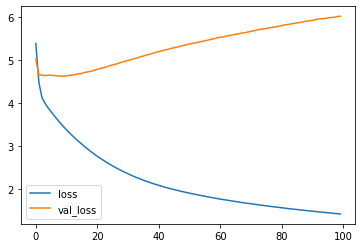

In [19]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))

x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(lr=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)


# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()



# # accuracies
# plt.plot(r.history['acc'], label='acc')
# plt.plot(r.history['val_acc'], label='val_acc')
# plt.legend()
# plt.show()


# make a sampling model
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])


# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}

In [20]:
sampling_model

In [21]:
def sample_line():
    # initial inputs
    np_input = np.array([[ word2idx['<sos>'] ]])
    h = np.zeros((1, LATENT_DIM))
    c = np.zeros((1, LATENT_DIM))

    # so we know when to quit
    eos = word2idx['<eos>']

    # store the output here
    output_sentence = []

    for _ in range(max_sequence_length):
        o, h, c = sampling_model.predict([np_input, h, c])

        # print("o.shape:", o.shape, o[0,0,:10])
        # idx = np.argmax(o[0,0])
        probs = o[0,0]
        if np.argmax(probs) == 0:
            print("wtf")
        probs[0] = 0
        probs /= probs.sum()
        idx = np.random.choice(len(probs), p=probs)
        if idx == eos:
            break

        # accuulate output
        output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

        # make the next input into model
        np_input[0,0] = idx

    return ' '.join(output_sentence)

In [22]:
# generate a 4 line poem

while True:
    for _ in range(4):
        print(sample_line())

    ans = input("---generate another? [Y/n]---")
    if ans and ans[0].lower().startswith('n'):
        break

up so as he he guessed of you have held the confusion
the headless aftermath,
now slowly closing like a mouth-
well, i were all married to go before
---generate another? [Y/n]---y
lifted the cellar going to sort of his eyes fire
till you're a piercing little boy,
someone came with cart and weary and you?'
as pale and dim as if some say a trapper looking in
---generate another? [Y/n]---y
it was going to hear to-day?'
the early mormons besides. like gnawed a shake our knees,
who i see?
two concerned for me
---generate another? [Y/n]---n
